<a href="https://colab.research.google.com/github/mgarciasanes/metodosdeagrupamiento_nosupervisado/blob/master/01_particiones_kmeanspp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> Aplicación de los Métodos de Agrupamiento</h1></center>
<center><h1> Aprendizaje No Supervisado</h1></center>
<center><h1> Agrupamiento por pareticiones : K-means++</h1></center>
<br>

### - Alexandro López González
### - Leonardo Pacheco Garduño
### - Manuel Garcia Sanes
<br>
<br>

En este notebook, realizaremos los siguiente:

- Aplicación del algoritmo K-means ++  a los dos datasets seleccionados. 

- Evaluación de los resultados utilizando métricas intrínsecas o extrínsecas según sea el caso

- Análisis del resultado
<br>
<br>


---
## 1. Cargamos las librerias necesarias   

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools as it



# Definimos las distancia euclidiana minima de una instancia x
# con respecto a un grupo de instancias c
def min_distancia_euclidiana_grupo(x, C):
    return np.min(np.sqrt(np.sum(np.power(C-x,2),axis=1)))

# Definimos la distancia euclidiana de una instancia x 
# con respecto a un grupo de instancias C
def distancia_euclidiana_grupo(x, C):   
    return np.sqrt(np.sum(np.power(C-x,2),axis=1))
  
  


## 2. Cargamos el dataset con agrupamiento conocido   

####Nombre:

SEEDS



####Abstract: <br>

Measurements of geometrical properties of kernels belonging to three different varieties of wheat. A soft X-ray technique and GRAINS package were used to construct all seven, real-valued attributes.
	
####Atributos (Reales): <br>
1. area A,
2. perimeter P,
3. compactness C = 4*pi*A/P^2,
4. length of kernel,
5. width of kernel,
6. asymmetry coefficient
7. length of kernel groove.
All of these parameters were real-valued continuous.

####Instancias: 
210

####URL: 
https://archive.ics.uci.edu/ml/datasets/seeds# <br>


El dataset cargado tiene 210 instancias, 7 atributos y 3 clusters.


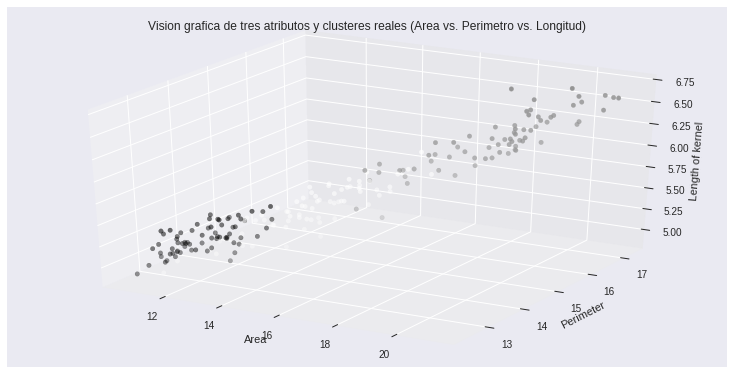

In [11]:
np.random.seed(31) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

#Cargamos los datos
data_file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'

#Mezclamos y separamos la columa clase  
D = np.array(pd.read_csv(data_file_url,delimiter='\s+', header=None))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:-1]
Dy = D[:,-1]

#Mostrar graficamente los datos (solo 3 atributos)
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 0], Dx[:, 1], Dx[:, 3], c=Dy)
ax.set_xlabel("Area")
ax.set_ylabel("Perimeter")
ax.set_zlabel("Length of kernel")
ax.set_title("Vision grafica de tres atributos y clusteres reales (Area vs. Perimetro vs. Longitud)")


print('El dataset cargado tiene',Dx.shape[0],'instancias,', Dx.shape[1], 'atributos y' ,len(np.unique(Dy)) , 'clusters.')

## 2.1 Aplicamos el Algoritmo seleccinado: K-means ++


El algoritmo K-means tiene un único parámetro: el número de clústeres (K). Una vez fijado este valor, el primer paso consiste en elegir unos centros iniciales.

Hemos querido incluir la representacion grafica de los datos. Aunque los datos tienen 7 atributos, representamos solo 3 de ellos:



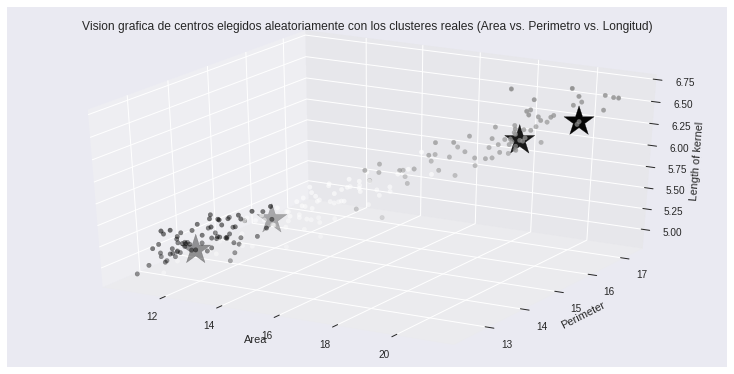

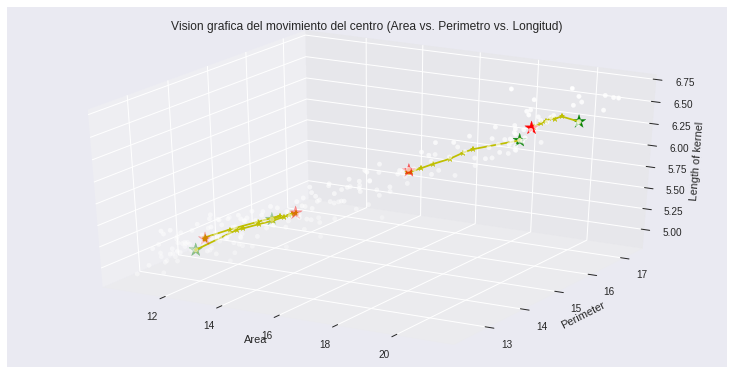

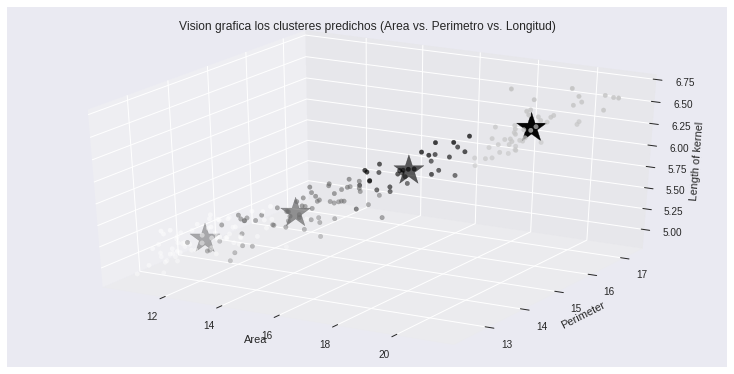

In [12]:
# Elegimos un número de clústeres a buscar (Sabemos que son 4)
K = 4
    
# Preparamos un arreglo para los centros   
cDx = np.zeros(Dx.shape[1])
cDx.shape = (1,Dx.shape[1])


icenter = np.random.randint(Dx.shape[0])
cDx[0,:] = Dx[icenter,:]
auxDx = np.delete(Dx, icenter, 0)


for k in np.arange(K-1):
    dist_min = np.zeros(auxDx.shape[0])
    for i in np.arange(auxDx.shape[0]):
        dist_min[i] = min_distancia_euclidiana_grupo(auxDx[i,:], cDx)
    probs = np.square(dist_min)/np.sum(np.square(dist_min))
    cumprobs = np.cumsum(probs)
    icenter = np.where(cumprobs >= np.random.random_sample())[0][0]
    cDx= np.append(cDx, np.matrix(auxDx[icenter,:]), axis=0)
    auxDx = np.delete(auxDx, icenter, 0)

#print('Los centros iniciales elegidos aleatoriamente son:')
#print(cDx)


fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 0], Dx[:, 1], Dx[:, 3], c=Dy)
ax.scatter(cDx[:, 0], cDx[:, 1], cDx[:, 3], marker='*', c='#050505', s=1000)
ax.set_xlabel("Area")
ax.set_ylabel("Perimeter")
ax.set_zlabel("Length of kernel")
ax.set_title("Vision grafica de centros elegidos aleatoriamente con los clusteres reales (Area vs. Perimetro vs. Longitud)")



# Preparamos el vector donde guardamos la asignación de cada elemento 
# a un clúster (1,...,K)
Dyp = np.zeros(Dx.shape[0])

# Preparamos la representacion grafica del progreso de seleccion de los centros
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 0], Dx[:, 1], Dx[:, 3], c=Dyp)
ax.scatter(cDx[:, 0], cDx[:, 1], cDx[:, 3], marker='*', c='g', s=200)
ax.set_xlabel("Area")
ax.set_ylabel("Perimeter")
ax.set_zlabel("Length of kernel")
ax.set_title("Vision grafica del movimiento del centro (Area vs. Perimetro vs. Longitud)")



# Flag de convergencia
iterando = True

# Iniciamos la iteracion...
while iterando:

    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()

    # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
    for i in np.arange(Dx.shape[0]):
        pred_y = np.argmin(distancia_euclidiana_grupo(Dx[i],cDx))
        Dyp[i] = pred_y

    # Calcular los nuevos centros
    for k in range(K):
        cDx[k,:] = Dx[Dyp==k].mean(axis=0)

    # Anadirlo a la grafica
    for k in np.arange(K):
        ax.plot( [cDx_ant[k,0], cDx[k,0]],[cDx_ant[k,1], cDx[k,1]],[cDx_ant[k,3], cDx[k,3]], linestyle='-', marker='*', c='y')
        
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)

    
# Anadimos los centros finales a la grafica con diferente color     
ax.scatter(np.array(cDx[:,0]),np.array(cDx[:,1]),np.array(cDx[:,3]) ,marker='*', s=200, c='r')


# Ver asignaciones finales
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 0], Dx[:, 1], Dx[:, 3], c=Dyp)
ax.scatter(cDx[:, 0], cDx[:, 1], cDx[:, 3], marker='*', c='#050505', s=1000)
ax.set_xlabel("Area")
ax.set_ylabel("Perimeter")
ax.set_zlabel("Length of kernel")
ax.set_title("Vision grafica los clusteres predichos (Area vs. Perimetro vs. Longitud)")
print("Hemos querido incluir la representacion grafica de los datos. Aunque los datos tienen 7 atributos, representamos solo 3 de ellos:")
print()

## 2.2 Evaluacion Extriniseca del Algoritmo seleccinado: K-means ++

- Matriz Confusion
- Informacion Mutua
- Valor de Error
- Pureza del Agrupamiento
- Precision
- Recall
- F1
- Entropia





In [15]:
def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i],cat_pred==clusts[j])) for j in np.arange(clusts.size)] for i in np.arange(cats.size)])
    return(mat)

def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def medida_precision(mat, l, k):
    return mat[l,k]/float(np.sum(mat[:,k]))

def medida_recall(mat, l, k):
    return mat[l,k]/float(np.sum(mat[l,:]))

def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    return np.sum([ float(np.sum(mat[:,k]))/float(np.sum(mat))
                   * np.max(mat[:,k]/float(np.sum(mat[:,k]))) for k in np.arange(mat.shape[1])])

def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return (2*prec*rec)/(prec+rec)

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign

def medida_entropia(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    relMat = mat/np.sum(mat,0)
    logRelMat = relMat.copy()
    logRelMat[logRelMat==0]=0.0001 # Evita el logaritmo de 0. Inofensivo pues luego desaparece al multiplicar por 0
    logRelMat = np.log(logRelMat)
    return -np.sum([totales[k] * np.sum([relMat[l,k]*logRelMat[l,k] 
                                         for l in np.arange(mat.shape[0])]) 
                    for k in np.arange(mat.shape[1])])

def medida_informacion_mutua(mat):
    relMat = mat/float(np.sum(mat))
    logRelMat = mat.copy()
    logRelMat = logRelMat/np.sum(mat,0,keepdims=True)
    logRelMat = logRelMat/np.sum(mat,1,keepdims=True)
    logRelMat[logRelMat==0]=0.000001 # Evita el logaritmo de 0. Inofensivo pues luego desaparece al multiplicar por 0
    logRelMat = np.log(float(np.sum(mat))*logRelMat) 
    return np.sum([np.sum([relMat[l,k]*logRelMat[l,k]
                           for l in np.arange(mat.shape[0])])
                   for k in np.arange(mat.shape[1])])

mC = matriz_confusion(Dy,Dyp)  
print("Matriz de Confusion")
print(mC)
print('La información mutua es = ', medida_informacion_mutua(mC))
print('El valor del error cometido es = ', medida_error(mC))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC))
print('Precision de l=1,k=1 es :' , medida_precision(mC,1,1))
print('Recall de l=1,k=1 es :' , medida_recall(mC,1,1))
print('El valor F1 es = ', medida_f1(mC))
print('La entropía es = ', medida_entropia(mC))

Matriz de Confusion
[[ 7  0 52 11]
 [ 0 48  0 22]
 [62  0  8  0]]
La información mutua es =  0.7785404720566337
El valor del error cometido es =  0.22857142857142854
La pureza del agrupamiento obtenido es =  0.8761904761904762
Precision de l=1,k=1 es : 1.0
Recall de l=1,k=1 es : 0.6857142857142857
El valor F1 es =  0.8352152176563834
La entropía es =  0.3200718166114761


## 2.3 Analisis de la evlauciaon del Algoritmo seleccinado: K-means ++


### ANALISIS AQUI


## 3. Cargamos el dataset con agrupamiento desconocido   

####Nombre:

ONLINE SHOPERS PURCHASING INTENTIONS



####Abstract: <br>

Of the 12,330 sessions in the dataset, 84.5% (10,422) were negative class samples that did not end with shopping, and the rest (1908) were positive class samples ending with shopping.
	.
	
	
####Atributos : <br>
1. Administrative
2. Administrative Duration
3. Informational
4. Informational Duration
5. Product Related
6. Product Related Duration 
7. Bounce Rate
8. Exit Rate
9. Page Value
10. Special Day 
11. month of the year
12. operating system
13. browser
14. region
15. traffic type
16. visitor type 
17. weekend
18. revenue


####Instancias: 
12330

####URL: 
https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset# <br>


El dataset cargado tiene 12330 instancias y  18  atributos


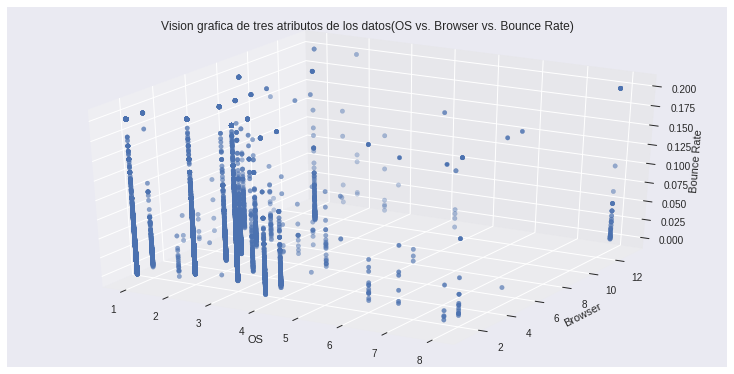

In [16]:
np.random.seed(31) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

#Cargamos los datos
data_file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv'

#Mezclamos   
D = np.array(pd.read_csv(data_file_url, header=0))
Dx = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]


# Mapear valores de texto a numeros. Columna 10 (month). Jan=1, Feb=2,...
for month,num in zip(['Jan', 'Feb', 'Mar' , 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],range(12)):
    Dx[Dx[:,10]==month,10]=num

# Mapear valores de texto a numeros. Columna 15 (Vistor_type). New_Visitor=1, Returning_Visitor=2,Other=3
Dx[Dx[:,15]=='New_Visitor',15]=1
Dx[Dx[:,15]=='Returning_Visitor',15]=2
Dx[Dx[:,15]=='Other',15]=3


# Mapear valores de texto a numeros. Columna 16 (wekend). 
for valor,num in zip([False, True],range(2)):
    Dx[Dx[:,16]==valor,16]=num

# Mapear valores de texto a numeros. Columna 17 (revenuw). 
for valor,num in zip([False, True],range(2)):
    Dx[Dx[:,17]==valor,17]=num
        
# Asgurandonos de usar float64
Dx=Dx.astype('float64')

#Mostrar graficamente los datos (solo 3 atributos)
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 11], Dx[:, 12], Dx[:, 7])
ax.set_xlabel("OS")
ax.set_ylabel("Browser")
ax.set_zlabel("Bounce Rate")
ax.set_title("Vision grafica de tres atributos de los datos(OS vs. Browser vs. Bounce Rate)")

print('El dataset cargado tiene',Dx.shape[0],'instancias y ', Dx.shape[1], ' atributos')

## 3.1 Aplicamos el Algoritmo seleccinado: K-means ++


El algoritmo K-means tiene un único parámetro: el número de clústeres (K). 


## 3.1.1 Eleccion de K (Regla del Codo)

Text(0, 0.5, 'Medida de R cuadrado')

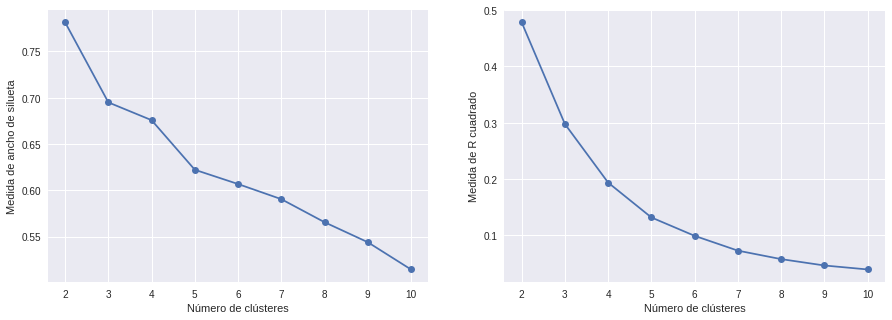

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


def medida_R_cuadrado(X, Xyp, cXs):
    cXglob = np.mean(X,axis=0) 
    labels = np.sort(np.unique(Xyp))
    sumTotal = np.sum(np.sum(X-cXglob,1)**2) 
    interior = np.sum([ np.sum(np.sum(X[Xyp==labels[k],:]-cXs[labels[k],:],1)**2) for k in np.arange(labels.size)])
    
    return interior/sumTotal 

rsilueta = np.zeros(9)
rrsquare = np.zeros(9)
for k in np.arange(2,11):
    modelo = KMeans(n_clusters=k)
    modelo = modelo.fit(Dx)
    Dyp_sk = modelo.predict(Dx)
    cDx_sk = modelo.cluster_centers_
    rsilueta[k-2] = silhouette_score(Dx, Dyp_sk)
    rrsquare[k-2]  = medida_R_cuadrado(Dx, Dyp_sk, cDx_sk)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot( np.arange(2,11),rsilueta, linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de ancho de silueta")

ax[1].plot( np.arange(2,11),rrsquare, linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Medida de R cuadrado")






## 3.1.2 Buscando Centroides ( K = 3 )

Los centros iniciales elegidos aleatoriamente son:
[[3.00000000e+00 1.51000000e+02 0.00000000e+00 0.00000000e+00
  2.10000000e+01 8.40286320e+02 0.00000000e+00 1.07638890e-02
  0.00000000e+00 0.00000000e+00 9.00000000e+00 2.00000000e+00
  2.00000000e+00 3.00000000e+00 2.00000000e+00 2.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.00000000e+00 3.39875000e+03 6.00000000e+00 2.54937500e+03
  4.49000000e+02 6.39735222e+04 7.64406000e-04 2.77013400e-02
  0.00000000e+00 0.00000000e+00 1.10000000e+01 2.00000000e+00
  2.00000000e+00 1.00000000e+00 2.00000000e+00 2.00000000e+00
  0.00000000e+00 0.00000000e+00]]


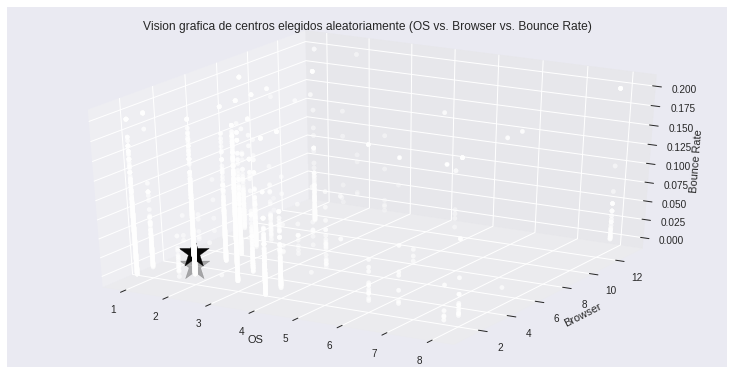

In [51]:
# Elegimos un número de clústeres a buscar (Sabemos que son 4)
K = 2
      
# Preparamos un arreglo para los centros   
cDx = np.zeros(Dx.shape[1])
cDx.shape = (1,Dx.shape[1])

icenter = np.random.randint(Dx.shape[0])
cDx[0,:] = Dx[icenter,:]
auxDx = np.delete(Dx, icenter, 0)
auxDx=auxDx.astype('float64')


for k in np.arange(K-1):
    dist_min = np.zeros(auxDx.shape[0])
    for i in np.arange(auxDx.shape[0]):
        dist_min[i] = min_distancia_euclidiana_grupo(auxDx[i,:], cDx)
    probs = np.square(dist_min)/np.sum(np.square(dist_min))
    cumprobs = np.cumsum(probs)
    icenter = np.where(cumprobs >= np.random.random_sample())[0][0]
    cDx= np.append(cDx, np.matrix(auxDx[icenter,:]), axis=0)
    auxDx = np.delete(auxDx, icenter, 0)


    
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 11], Dx[:, 12], Dx[:, 7],c='#FFFFFF')
ax.scatter(cDx[:,11], cDx[:, 12], cDx[:, 7], marker='*', c='#050505', s=1000)
ax.set_xlabel("OS")
ax.set_ylabel("Browser")
ax.set_zlabel("Bounce Rate")
ax.set_title("Vision grafica de centros elegidos aleatoriamente (OS vs. Browser vs. Bounce Rate)")


    
print('Los centros iniciales elegidos aleatoriamente son:')
print(cDx)



## 3.1.3 Aplicando Algoritmo 


Hemos querido incluir la representacion grafica de los datos. Aunque los datos tienen 7 atributos, representamos solo 3 de ellos:



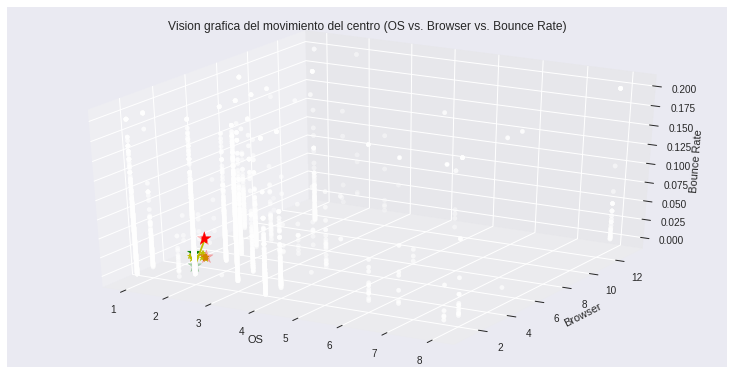

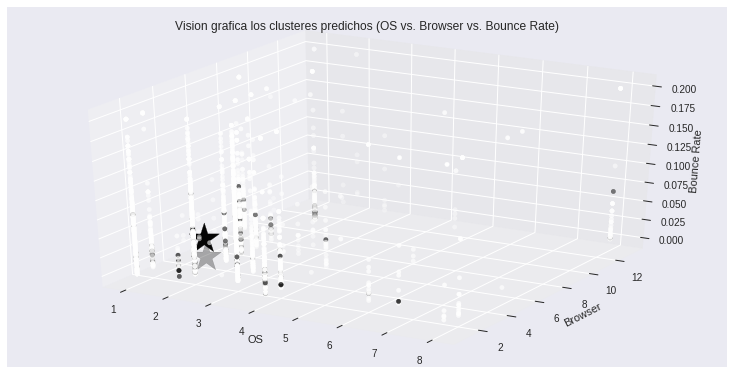

In [52]:


# Preparamos el vector donde guardamos la asignación de cada elemento 
# a un clúster (1,...,K)
Dyp = np.zeros(Dx.shape[0])

# Preparamos la representacion grafica del progreso de seleccion de los centros
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:,11], Dx[:,12], Dx[:,7], c=Dyp)
ax.scatter(cDx[:,11], cDx[:,12], cDx[:,7], marker='*', c='g', s=200)
ax.set_xlabel("OS")
ax.set_ylabel("Browser")
ax.set_zlabel("Bounce Rate")
ax.set_title("Vision grafica del movimiento del centro (OS vs. Browser vs. Bounce Rate)")


# Flag de convergencia
iterando = True

# Iniciamos la iteracion...
while iterando:

    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()

    # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
    for i in np.arange(Dx.shape[0]):
        pred_y = np.argmin(distancia_euclidiana_grupo(Dx[i],cDx))
        Dyp[i] = pred_y

    # Calcular los nuevos centros
    for k in range(K):
        cDx[k,:] = Dx[Dyp==k].mean(axis=0)

    # Anadirlo a la grafica
    for k in np.arange(K):
        ax.plot( [cDx_ant[k,11], cDx[k,11]],[cDx_ant[k,12], cDx[k,12]],[cDx_ant[k,7], cDx[k,7]], linestyle='-', marker='*', c='y')
        
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)

    
# Anadimos los centros finales a la grafica con diferente color     
ax.scatter(np.array(cDx[:,11]),np.array(cDx[:,12]),np.array(cDx[:,7]) ,marker='*', s=200, c='r')


# Ver asignaciones finales
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 11], Dx[:, 12], Dx[:, 7], c=Dyp)
ax.scatter(cDx[:, 11], cDx[:, 12], cDx[:, 7], marker='*', c='#050505', s=1000)
ax.set_xlabel("OS")
ax.set_ylabel("Browser")
ax.set_zlabel("Bounce Rate")
ax.set_title("Vision grafica los clusteres predichos (OS vs. Browser vs. Bounce Rate)")
print("Hemos querido incluir la representacion grafica de los datos. Aunque los datos tienen 7 atributos, representamos solo 3 de ellos:")
print()

## 3.2 Evaluacion Intrinseca del Algoritmo seleccinado: K-means ++

1.   List item
2.   List item



In [0]:
def medida_RMSSTD(X, Xyp, cXs):
    labels = np.unique(Xyp)
    labels=labels.astype('int')
    num = np.sum([ np.sum(np.sum(X[Xyp==labels[k],:]-cXs[labels[k],:],1)**2) for k in np.arange(labels.size)])
    den = X.shape[1] * np.sum([np.sum(Xyp==labels[k])-1 for k in np.arange(labels.size)])
    return np.sqrt(num/den)
  
def medida_R_cuadrado(X, Xyp, cXs):
    cXglob = np.mean(X,axis=0) 
    labels = np.sort(np.unique(Xyp)).astype('int')
    sumTotal = np.sum(np.sum(X-cXglob,1)**2) 
    interior = np.sum([ np.sum(np.sum(X[Xyp==labels[k],:]-cXs[labels[k],:],1)**2) for k in np.arange(labels.size)])
    return interior/sumTotal 

def distancia_euclidiana(x, y):   
    return np.sqrt(np.sum((x - y) ** 2))

def matriz_distancias(X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD

def calcular_matriz_a(X, Xyp, mD):
    labels = np.sort(np.unique(Xyp))
    factores = 1.0/(np.array([np.sum(Xyp==labels[k]) for k in np.arange(labels.size)])-1)
    aX = np.zeros(X.shape[0])
    for i in np.arange(X.shape[0]):
        k = Xyp[i]
        aX[i] = factores[k] * np.sum([mD[i,ip] 
                                      for ip in np.arange(X.shape[0])[Xyp==labels[k]]])
    return(aX)

def calcular_matriz_b(X, Xyp, mD):
    labels = np.sort(np.unique(Xyp))
    factores = 1.0/np.array([np.sum(Xyp==labels[k]) for k in np.arange(labels.size)])
    bX = np.zeros(X.shape[0])
    for i in np.arange(X.shape[0]):
        k = Xyp[i]
        ran = np.arange(labels.size)
        ran = ran[np.arange(labels.size)!=k]
        res = np.array([factores[h] * np.sum([mD[i,ip]
                                              for ip in np.arange(X.shape[0])[Xyp==labels[h]]])
                        for h in ran])
        bX[i] = np.min(res)
    return(bX)

def medida_silueta(X, Xyp, distancia):
    mD = matriz_distancias(X, distancia)
    A = calcular_matriz_a(X, Xyp, mD)
    B = calcular_matriz_b(X, Xyp, mD)
    impl = (B-A)/np.maximum(A,B)
    return np.mean(impl)


def medida_calinski_harabasz(X, Xyp, cXs, distancia):
    cXglob = np.mean(X,axis=0) 
    labels = np.sort(np.unique(Xyp))
    factores = np.array([np.sum(Xyp==labels[k]) for k in np.arange(labels.size)])
    num = (X.shape[0]-labels.size)*np.sum([factores[k]*distancia(cXs[k,:],cXglob)**2 
                                           for k in np.arange(cXs.shape[0])])
    den = (labels.size-1)*np.sum([np.sum([distancia(X[i,:],cXs[k,:])**2 
                                            for i in np.arange(X.shape[0])[Xyp==labels[k]]])
                                           for k in np.arange(cXs.shape[0])])
    return num/den


def medida_I(X, Xyp, cXs, distancia):
    cXglob = np.mean(X, axis = 0) 
    labels = np.sort(np.unique(Xyp))
    maxDcs = np.max(matriz_distancias(cXs, distancia))
    num = np.sum([distancia(X[i,:], cXglob) for i in np.arange(X.shape[0])])
    den = labels.size * np.sum([np.sum([distancia(X[i,:], cXs[k,:])
                                        for i in np.arange(X.shape[0])[Xyp==labels[k]]])
                                for k in np.arange(cXs.shape[0])])
    return (num*maxDcs/den)**2


def medida_davies_bouldin(X, Xyp, cXs, distancia):
    labels = np.sort(np.unique(Xyp))
    mDcs = matriz_distancias(cXs, distancia)
    np.fill_diagonal(mDcs, np.Infinity)
    vals = np.array([1.0 / np.sum(Xyp==labels[k]) * np.sum([distancia(X[i,:], cXs[k,:])
                                                            for i in np.arange(X.shape[0])[Xyp==labels[k]]])
                     for k in np.arange(cXs.shape[0])])
    res = 1.0/labels.size*np.sum([np.max([(vals[k]+vals[kp])/mDcs[k,kp] 
                                          for kp in np.arange(labels.size)])
                                  for k in np.arange(labels.size)])
    return res

cDx= np.squeeze(np.asarray(cDx))
print('El error RMSSTD es = ',medida_RMSSTD(Dx, Dyp, cDx))
print('El valor de la medida R cuadrado es = ', medida_R_cuadrado(Dx, Dyp, cDx))
#print('El valor de la medida Silueta es = ', medida_silueta(Dx, Dyp, distancia_euclidiana))
print('El valor de la medida Calinski-Harabasz es = ', medida_calinski_harabasz(Dx, Dyp, cDx, distancia_euclidiana))
print('El valor de la medida I es = ', medida_I(Dx, Dyp, cDx, distancia_euclidiana))
print('El valor de la medida Davies-Bouldin es = ', medida_davies_bouldin(Dx, Dyp, cDx, distancia_euclidiana))




El error RMSSTD es =  339.01802042476885
El valor de la medida R cuadrado es =  0.4784712256473076


## 3.3 Analisis de la evlauciaon del Algoritmo seleccinado: K-means ++


### ANALISIS AQUI